# Setup


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import random
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.cluster import DBSCAN
import math
import statistics
pd.options.mode.chained_assignment = None  # default='warn'
import itertools
import json
from confidence_functions.confidence import *

#Convert CSV to Dataframe"C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\data\pairwise_user_experiment.csv"
data = pd.read_csv("./data/pairwise_user_experiment.csv", header=[0])
data["FOLDER"] = data["IN FILE"].apply(lambda x: "")
data["LAST MOD BY"] = data["LAST MOD BY"].apply(lambda x: x.split(" ")[0])
data

,IN FILE,CLIP LENGTH,OFFSET,DURATION,MAX FREQ,MIN FREQ,SAMPLE RATE,MANUAL ID,TIME_SPENT,LAST MOD BY,CONFIDENCE,RETIRED,COUNTED,FOLDER
0,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,1.1839,1.3399,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
1,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,6.9715,1.5479,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
2,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,8.8594,0.4500,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
3,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,9.9393,1.0800,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
4,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,15.1890,0.9299,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,XC688950_-_Balearic_Warbler_-_Sylvia_balearica...,25.9531,22.3916,0.8100,24000,0,48000,bird,311.194,Anshul,0.300511,False,0,
2244,XC688950_-_Balearic_Warbler_-_Sylvia_balearica...,25.9531,23.7316,0.1600,24000,0,48000,bird,311.194,Anshul,0.300511,False,0,
2245,XC688950_-_Balearic_Warbler_-_Sylvia_balearica...,25.9531,24.2615,0.1200,24000,0,48000,bird,311.194,Anshul,0.300511,False,0,
2246,XC688950_-_Balearic_Warbler_-_Sylvia_balearica...,25.9531,24.7815,0.1600,24000,0,48000,bird,311.194,Anshul,0.300511,False,0,


In [3]:
import time

 
confidence_funcs = [ get_silhoutte_confidence, get_silhoutte_users_confidence, fast_majority_vote, get_pairwise_iou]
confidence_funcs

def experiment_3(df, confidence_funcs, num_of_trials=10, json_name="experiment_results.json"):
    results = {}
    users = df["LAST MOD BY"].unique()
    files = df["IN FILE"].unique()
    for func in confidence_funcs:
        results[func.__name__] = {}
        for i in range (len(users)):
            results[func.__name__][i] = []
        results[func.__name__]["TIMING"] = []
    
    
    for trial in range(num_of_trials):
        start = time.time()
        print("============================")
        print(trial)
        file  = np.random.choice(files, size=None, replace=True, p=None)
        tmp_df = df[df["IN FILE"] == file]
        users = tmp_df["LAST MOD BY"].unique()

        to_be_randomly_inserted = np.tile(users, (1, 1))
        to_be_randomly_inserted = pd.DataFrame(to_be_randomly_inserted)
        to_be_randomly_inserted = to_be_randomly_inserted.apply(lambda x:np.random.shuffle(x.to_numpy()) or x.to_numpy(), axis=1)
        random_insertion_orders = to_be_randomly_inserted.values
        
        end = time.time()
        #print("Set Up", end - start)
        
        for insertion_order in random_insertion_orders:
            for func in confidence_funcs:
                start = time.time()
                for user_count in range(1,len(insertion_order)):
                    curr_insert = insertion_order[:user_count+1]
                    tmp_df_users = tmp_df[tmp_df["LAST MOD BY"].isin(curr_insert)]
                    try:
                        results[func.__name__][user_count].append(func(tmp_df_users, curr_insert))
                    except:
                        pass
                end = time.time()
                print(func.__name__, end - start)
                results[func.__name__]["TIMING"].append(end - start)
                    
        results["TRIAL COUNT"] = trial
        json_object = json.dumps(results, indent=4)
 
        # Writing to sample.json
        with open(json_name, "w") as outfile:
            outfile.write(json_object)
        
    return results


def process_results(experiment_results):
    #print(experiment_results)
    print ("trails ran",  experiment_results["TRIAL COUNT"])
    del experiment_results["TRIAL COUNT"]
    
    for confidence_func in experiment_results:
        confidence_dirc = experiment_results[confidence_func]
        print("Time for ", confidence_func, " was ", np.mean(confidence_dirc["TIMING"]))
        del confidence_dirc["TIMING"]
        users_count = list(confidence_dirc.keys())
        #for count in users_count:
        #    experiment_results[confidence_func][count] = np.array(confidence_dirc[count])#.mean()
    return experiment_results


def plot_change_in_ci(experiment_results):
    for confidence_func in experiment_results:
        confidence_dirc = experiment_results[confidence_func]
        
        users_count = list(confidence_dirc.keys())
        raw_score = list(confidence_dirc.values())
        CI = []
        #plot CI
        for count in users_count:
            if (count == 0):continue
            scores_for_count = np.array(raw_score[int(count)-1])                            
            ci = 0.1 * float(np.std(scores_for_count)) / float(np.mean(scores_for_count))
            CI.append(ci * 2)
        p = plt.plot(users_count[1:], CI, label=(confidence_func))
        

    #Throw in some fancy formatting
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title("Change in Confidence Interval of User Scores per Function")
    plt.xlabel("Number of users who annotated")
    plt.ylabel("CI of Function")
    plt.show()

def generate_graph_all(experiment_results):
    #For each filename, plot the performance of each confidence function
    for confidence_func in experiment_results:
        confidence_dirc = experiment_results[confidence_func]
        
        users_count = list(confidence_dirc.keys())
        raw_score = list(confidence_dirc.values())
        
        #plot mean
        score_mean = []
        for count in users_count:
            if (count == 0):continue
            score_mean.append(np.array(raw_score[int(count)]).mean())
        p = plt.plot(users_count[1:], score_mean, label=(confidence_func))
        #plot CI
        
        print(users_count)
        for count in users_count:
            if (count == 0):continue
            print(raw_score[int(count)])
            scores_for_count = np.array(raw_score[int(count)])
            y = scores_for_count.mean()
            ci = 0.1 * np.std(scores_for_count) / np.mean(scores_for_count)
            plt.fill_between([count], (y-ci), (y+ci), color=p[0].get_color(), alpha=0.5)
        

    #Throw in some fancy formatting
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title("Change in user agreement scores per Function")
    plt.xlabel("Number of users who annotated")
    plt.ylabel("Average Confidence of Function For Number Of Users")
    plt.show()


# Rerun Old Experiment

0
get_silhoutte_confidence 0.33655643463134766
get_silhoutte_users_confidence 0.33056211471557617
fast_majority_vote 1.1812260150909424
get_pairwise_iou 2.9653849601745605
1
get_silhoutte_confidence 0.16152691841125488
get_silhoutte_users_confidence 0.16403770446777344
fast_majority_vote 0.5062465667724609
get_pairwise_iou 1.5017399787902832
2
get_silhoutte_confidence 0.23458433151245117
get_silhoutte_users_confidence 0.2326817512512207
fast_majority_vote 1.4346258640289307
get_pairwise_iou 2.8884263038635254
3
get_silhoutte_confidence 0.1580352783203125
get_silhoutte_users_confidence 0.15952420234680176
fast_majority_vote 0.5025925636291504
get_pairwise_iou 0.7539901733398438
4
get_silhoutte_confidence 0.15412473678588867
get_silhoutte_users_confidence 0.15602993965148926
fast_majority_vote 0.29756760597229004
get_pairwise_iou 0.7898128032684326
5
get_silhoutte_confidence 0.16164350509643555
get_silhoutte_users_confidence 0.16453790664672852
fast_majority_vote 1.3692238330841064
get_p

get_pairwise_iou 7.332696914672852
41
get_silhoutte_confidence 0.44861626625061035
get_silhoutte_users_confidence 0.4412729740142822
fast_majority_vote 3.375621795654297
get_pairwise_iou 7.846799373626709
42
get_silhoutte_confidence 0.24551916122436523
get_silhoutte_users_confidence 0.24902796745300293
fast_majority_vote 0.5216059684753418
get_pairwise_iou 1.561690092086792
43
get_silhoutte_confidence 0.19956660270690918
get_silhoutte_users_confidence 0.2069716453552246
fast_majority_vote 0.6736023426055908
get_pairwise_iou 1.5447885990142822
44
get_silhoutte_confidence 0.18296074867248535
get_silhoutte_users_confidence 0.18304157257080078
fast_majority_vote 0.7665622234344482
get_pairwise_iou 1.49183988571167
45
get_silhoutte_confidence 0.45609331130981445
get_silhoutte_users_confidence 0.4677400588989258
fast_majority_vote 3.329831600189209
get_pairwise_iou 7.742392539978027
46
get_silhoutte_confidence 0.1610250473022461
get_silhoutte_users_confidence 0.166520357131958
fast_majority_

get_pairwise_iou 0.7881555557250977
82
get_silhoutte_confidence 0.32588911056518555
get_silhoutte_users_confidence 0.31854748725891113
fast_majority_vote 1.2536132335662842
get_pairwise_iou 2.5148091316223145
83
get_silhoutte_confidence 0.19704103469848633
get_silhoutte_users_confidence 0.20603108406066895
fast_majority_vote 0.37284088134765625
get_pairwise_iou 0.7947843074798584
84
get_silhoutte_confidence 0.17704534530639648
get_silhoutte_users_confidence 0.17352294921875
fast_majority_vote 0.44881248474121094
get_pairwise_iou 1.5716133117675781
85
get_silhoutte_confidence 0.19855427742004395
get_silhoutte_users_confidence 0.2000443935394287
fast_majority_vote 1.3294692039489746
get_pairwise_iou 3.52614688873291
86
get_silhoutte_confidence 0.22362899780273438
get_silhoutte_users_confidence 0.22408413887023926
fast_majority_vote 0.7532224655151367
get_pairwise_iou 1.6070868968963623
87
get_silhoutte_confidence 0.26129889488220215
get_silhoutte_users_confidence 0.2720828056335449
fast_

fast_majority_vote 0.5061919689178467
get_pairwise_iou 1.6181862354278564
123
get_silhoutte_confidence 0.19840788841247559
get_silhoutte_users_confidence 0.2072279453277588
fast_majority_vote 0.37306785583496094
get_pairwise_iou 0.7951943874359131
124
get_silhoutte_confidence 0.22401785850524902
get_silhoutte_users_confidence 0.21807003021240234
fast_majority_vote 1.299466848373413
get_pairwise_iou 3.978386402130127
125
get_silhoutte_confidence 0.15002202987670898
get_silhoutte_users_confidence 0.14815950393676758
fast_majority_vote 0.370586633682251
get_pairwise_iou 0.6011199951171875
126
get_silhoutte_confidence 0.08351469039916992
get_silhoutte_users_confidence 0.0815134048461914
fast_majority_vote 0.23304200172424316
get_pairwise_iou 0.5628259181976318
127
get_silhoutte_confidence 0.20302724838256836
get_silhoutte_users_confidence 0.2029409408569336
fast_majority_vote 0.5015745162963867
get_pairwise_iou 1.241856575012207
128
get_silhoutte_confidence 0.08000564575195312
get_silhoutt

get_silhoutte_confidence 0.17952656745910645
get_silhoutte_users_confidence 0.18202900886535645
fast_majority_vote 0.7639224529266357
get_pairwise_iou 1.4555060863494873
164
get_silhoutte_confidence 0.20103859901428223
get_silhoutte_users_confidence 0.1995556354522705
fast_majority_vote 1.079206943511963
get_pairwise_iou 1.5930938720703125
165
get_silhoutte_confidence 0.1445603370666504
get_silhoutte_users_confidence 0.14852023124694824
fast_majority_vote 0.5120935440063477
get_pairwise_iou 0.6275885105133057
166
get_silhoutte_confidence 0.11651873588562012
get_silhoutte_users_confidence 0.11751270294189453
fast_majority_vote 0.29055023193359375
get_pairwise_iou 0.5072968006134033
167
get_silhoutte_confidence 0.19903969764709473
get_silhoutte_users_confidence 0.1985795497894287
fast_majority_vote 0.6626312732696533
get_pairwise_iou 1.4673848152160645
168
get_silhoutte_confidence 0.3275585174560547
get_silhoutte_users_confidence 0.3235495090484619
fast_majority_vote 1.1602094173431396
g

get_pairwise_iou 2.6759226322174072
204
get_silhoutte_confidence 0.34054994583129883
get_silhoutte_users_confidence 0.33664917945861816
fast_majority_vote 1.409254789352417
get_pairwise_iou 3.7724993228912354
205
get_silhoutte_confidence 0.14851784706115723
get_silhoutte_users_confidence 0.14852523803710938
fast_majority_vote 0.5076911449432373
get_pairwise_iou 1.300102949142456
206
get_silhoutte_confidence 0.23102831840515137
get_silhoutte_users_confidence 0.23360109329223633
fast_majority_vote 1.35133695602417
get_pairwise_iou 4.088945388793945
207
get_silhoutte_confidence 0.35124707221984863
get_silhoutte_users_confidence 0.35306477546691895
fast_majority_vote 1.6916401386260986
get_pairwise_iou 4.033302307128906
208
get_silhoutte_confidence 0.1540360450744629
get_silhoutte_users_confidence 0.15408539772033691
fast_majority_vote 0.45433855056762695
get_pairwise_iou 1.2252838611602783
209
get_silhoutte_confidence 0.22496795654296875
get_silhoutte_users_confidence 0.2270042896270752
f

get_silhoutte_users_confidence 0.21631217002868652
fast_majority_vote 0.6410765647888184
get_pairwise_iou 1.4671838283538818
245
get_silhoutte_confidence 0.18767666816711426
get_silhoutte_users_confidence 0.18706202507019043
fast_majority_vote 0.6647319793701172
get_pairwise_iou 1.3052525520324707
246
get_silhoutte_confidence 0.23161077499389648
get_silhoutte_users_confidence 0.2337191104888916
fast_majority_vote 1.436643123626709
get_pairwise_iou 2.6138548851013184
247
get_silhoutte_confidence 0.17636966705322266
get_silhoutte_users_confidence 0.18169832229614258
fast_majority_vote 0.507826566696167
get_pairwise_iou 1.1020655632019043
248
get_silhoutte_confidence 0.1489250659942627
get_silhoutte_users_confidence 0.1510467529296875
fast_majority_vote 0.36521267890930176
get_pairwise_iou 0.6074590682983398
249
get_silhoutte_confidence 0.1622781753540039
get_silhoutte_users_confidence 0.1623859405517578
fast_majority_vote 0.6514792442321777
get_pairwise_iou 1.0723423957824707
250
get_sil

get_silhoutte_confidence 0.20581674575805664
get_silhoutte_users_confidence 0.20325613021850586
fast_majority_vote 1.0166687965393066
get_pairwise_iou 2.1683835983276367
286
get_silhoutte_confidence 0.22916531562805176
get_silhoutte_users_confidence 0.22611403465270996
fast_majority_vote 0.31528735160827637
get_pairwise_iou 0.7788128852844238
287
get_silhoutte_confidence 0.0775156021118164
get_silhoutte_users_confidence 0.07800412178039551
fast_majority_vote 0.22855854034423828
get_pairwise_iou 0.594658613204956
288
get_silhoutte_confidence 0.16652584075927734
get_silhoutte_users_confidence 0.16776037216186523
fast_majority_vote 0.509587287902832
get_pairwise_iou 1.3453724384307861
289
get_silhoutte_confidence 0.23303556442260742
get_silhoutte_users_confidence 0.23056578636169434
fast_majority_vote 1.2958745956420898
get_pairwise_iou 3.900444507598877
290
get_silhoutte_confidence 0.24366974830627441
get_silhoutte_users_confidence 0.2419421672821045
fast_majority_vote 0.5141897201538086

get_pairwise_iou 0.7001023292541504
326
get_silhoutte_confidence 0.16093707084655762
get_silhoutte_users_confidence 0.1592864990234375
fast_majority_vote 0.5300612449645996
get_pairwise_iou 1.5170032978057861
327
get_silhoutte_confidence 0.18527936935424805
get_silhoutte_users_confidence 0.19649767875671387
fast_majority_vote 0.6745319366455078
get_pairwise_iou 1.0714831352233887
328
get_silhoutte_confidence 0.1560816764831543
get_silhoutte_users_confidence 0.15909504890441895
fast_majority_vote 0.3625199794769287
get_pairwise_iou 0.8111999034881592
329
get_silhoutte_confidence 0.23162364959716797
get_silhoutte_users_confidence 0.23492789268493652
fast_majority_vote 0.7784953117370605
get_pairwise_iou 1.4294707775115967
330
get_silhoutte_confidence 0.1722571849822998
get_silhoutte_users_confidence 0.1746530532836914
fast_majority_vote 0.27728843688964844
get_pairwise_iou 0.6989626884460449
331
get_silhoutte_confidence 0.21581745147705078
get_silhoutte_users_confidence 0.216501712799072

fast_majority_vote 0.8598554134368896
get_pairwise_iou 2.2471659183502197
367
get_silhoutte_confidence 0.39908885955810547
get_silhoutte_users_confidence 0.39407825469970703
fast_majority_vote 1.2132134437561035
get_pairwise_iou 2.3222763538360596
368
get_silhoutte_confidence 0.1756598949432373
get_silhoutte_users_confidence 0.1660451889038086
fast_majority_vote 0.4942293167114258
get_pairwise_iou 1.118288516998291
369
get_silhoutte_confidence 0.44513368606567383
get_silhoutte_users_confidence 0.5575962066650391
fast_majority_vote 3.881631374359131
get_pairwise_iou 9.155237674713135
370
get_silhoutte_confidence 0.29207897186279297
get_silhoutte_users_confidence 0.2960782051086426
fast_majority_vote 1.3575084209442139
get_pairwise_iou 2.7122433185577393
371
get_silhoutte_confidence 0.14303970336914062
get_silhoutte_users_confidence 0.14505243301391602
fast_majority_vote 0.6034836769104004
get_pairwise_iou 1.0292599201202393
372
get_silhoutte_confidence 0.30455875396728516
get_silhoutte_

get_silhoutte_users_confidence 0.21503043174743652
fast_majority_vote 1.4638400077819824
get_pairwise_iou 2.772106170654297
408
get_silhoutte_confidence 0.21503520011901855
get_silhoutte_users_confidence 0.21038103103637695
fast_majority_vote 1.3077881336212158
get_pairwise_iou 3.6801908016204834
409
get_silhoutte_confidence 0.17403745651245117
get_silhoutte_users_confidence 0.17728686332702637
fast_majority_vote 0.356109619140625
get_pairwise_iou 0.7302324771881104
410
get_silhoutte_confidence 0.20704007148742676
get_silhoutte_users_confidence 0.20060515403747559
fast_majority_vote 0.47008514404296875
get_pairwise_iou 1.2657732963562012
411
get_silhoutte_confidence 0.2280900478363037
get_silhoutte_users_confidence 0.2075519561767578
fast_majority_vote 0.3900599479675293
get_pairwise_iou 0.6707842350006104
412
get_silhoutte_confidence 0.16351985931396484
get_silhoutte_users_confidence 0.16196894645690918
fast_majority_vote 0.5085635185241699
get_pairwise_iou 1.5093038082122803
413
get_

get_silhoutte_confidence 0.24054646492004395
get_silhoutte_users_confidence 0.24229073524475098
fast_majority_vote 1.349299430847168
get_pairwise_iou 4.250686407089233
449
get_silhoutte_confidence 0.11452150344848633
get_silhoutte_users_confidence 0.11453652381896973
fast_majority_vote 0.1990365982055664
get_pairwise_iou 0.5857698917388916
450
get_silhoutte_confidence 0.13851666450500488
get_silhoutte_users_confidence 0.14213919639587402
fast_majority_vote 0.3535745143890381
get_pairwise_iou 0.5251345634460449
451
get_silhoutte_confidence 0.15503406524658203
get_silhoutte_users_confidence 0.1560361385345459
fast_majority_vote 0.693382740020752
get_pairwise_iou 1.6119880676269531
452
get_silhoutte_confidence 0.12851619720458984
get_silhoutte_users_confidence 0.12852692604064941
fast_majority_vote 0.5087504386901855
get_pairwise_iou 0.7719948291778564
453
get_silhoutte_confidence 0.17652034759521484
get_silhoutte_users_confidence 0.17805910110473633
fast_majority_vote 0.352846622467041
g

get_pairwise_iou 0.6163167953491211
489
get_silhoutte_confidence 0.24755597114562988
get_silhoutte_users_confidence 0.24596381187438965
fast_majority_vote 1.373534917831421
get_pairwise_iou 4.3574957847595215
490
get_silhoutte_confidence 0.2680022716522217
get_silhoutte_users_confidence 0.2725076675415039
fast_majority_vote 1.515798807144165
get_pairwise_iou 2.8244245052337646
491
get_silhoutte_confidence 0.1625199317932129
get_silhoutte_users_confidence 0.16770553588867188
fast_majority_vote 0.5437836647033691
get_pairwise_iou 1.3004043102264404
492
get_silhoutte_confidence 0.21703624725341797
get_silhoutte_users_confidence 0.2180335521697998
fast_majority_vote 0.6227221488952637
get_pairwise_iou 1.165029764175415
493
get_silhoutte_confidence 0.1970365047454834
get_silhoutte_users_confidence 0.1930398941040039
fast_majority_vote 0.3600888252258301
get_pairwise_iou 0.7861247062683105
494
get_silhoutte_confidence 0.14452624320983887
get_silhoutte_users_confidence 0.1480238437652588
fast

fast_majority_vote 0.39463353157043457
get_pairwise_iou 0.678372859954834
530
get_silhoutte_confidence 0.16503334045410156
get_silhoutte_users_confidence 0.1660451889038086
fast_majority_vote 0.4976184368133545
get_pairwise_iou 1.3127551078796387
531
get_silhoutte_confidence 0.23504638671875
get_silhoutte_users_confidence 0.22372698783874512
fast_majority_vote 1.2692983150482178
get_pairwise_iou 3.5009660720825195
532
get_silhoutte_confidence 0.2070293426513672
get_silhoutte_users_confidence 0.20304632186889648
fast_majority_vote 0.659109354019165
get_pairwise_iou 1.6029722690582275
533
get_silhoutte_confidence 0.13051199913024902
get_silhoutte_users_confidence 0.13153338432312012
fast_majority_vote 0.5591013431549072
get_pairwise_iou 0.6300959587097168
534
get_silhoutte_confidence 0.18451976776123047
get_silhoutte_users_confidence 0.18662333488464355
fast_majority_vote 1.08860445022583
get_pairwise_iou 1.498666524887085
535
get_silhoutte_confidence 0.16102910041809082
get_silhoutte_us

get_silhoutte_users_confidence 0.13052940368652344
fast_majority_vote 0.5461127758026123
get_pairwise_iou 0.6309010982513428
571
get_silhoutte_confidence 0.4446990489959717
get_silhoutte_users_confidence 0.44209814071655273
fast_majority_vote 3.478057622909546
get_pairwise_iou 8.032575130462646
572
get_silhoutte_confidence 0.1830430030822754
get_silhoutte_users_confidence 0.18352627754211426
fast_majority_vote 0.6643335819244385
get_pairwise_iou 1.2337329387664795
573
get_silhoutte_confidence 0.48159313201904297
get_silhoutte_users_confidence 0.47506022453308105
fast_majority_vote 3.445075750350952
get_pairwise_iou 9.505309820175171
574
get_silhoutte_confidence 0.20305275917053223
get_silhoutte_users_confidence 0.19979190826416016
fast_majority_vote 0.94195556640625
get_pairwise_iou 1.5886547565460205
575
get_silhoutte_confidence 0.20199823379516602
get_silhoutte_users_confidence 0.19304394721984863
fast_majority_vote 0.37123870849609375
get_pairwise_iou 0.826977014541626
576
get_silho

get_silhoutte_confidence 0.35508275032043457
get_silhoutte_users_confidence 0.3561224937438965
fast_majority_vote 1.602174997329712
get_pairwise_iou 3.6691341400146484
612
get_silhoutte_confidence 0.24954938888549805
get_silhoutte_users_confidence 0.24802851676940918
fast_majority_vote 0.4942023754119873
get_pairwise_iou 1.4071834087371826
613
get_silhoutte_confidence 0.16951680183410645
get_silhoutte_users_confidence 0.17105770111083984
fast_majority_vote 0.46599507331848145
get_pairwise_iou 1.5323681831359863
614
get_silhoutte_confidence 0.22017335891723633
get_silhoutte_users_confidence 0.21863865852355957
fast_majority_vote 0.4932899475097656
get_pairwise_iou 1.2420594692230225
615
get_silhoutte_confidence 0.2065873146057129
get_silhoutte_users_confidence 0.2070302963256836
fast_majority_vote 1.0398468971252441
get_pairwise_iou 2.4596333503723145
616
get_silhoutte_confidence 0.1830282211303711
get_silhoutte_users_confidence 0.19631290435791016
fast_majority_vote 0.3445618152618408


get_pairwise_iou 0.5840954780578613
652
get_silhoutte_confidence 0.1655120849609375
get_silhoutte_users_confidence 0.1660301685333252
fast_majority_vote 0.4675869941711426
get_pairwise_iou 1.1924421787261963
653
get_silhoutte_confidence 0.09048700332641602
get_silhoutte_users_confidence 0.0905160903930664
fast_majority_vote 0.9320893287658691
get_pairwise_iou 1.9334378242492676
654
get_silhoutte_confidence 0.09252548217773438
get_silhoutte_users_confidence 0.0925145149230957
fast_majority_vote 0.208632230758667
get_pairwise_iou 0.5896902084350586
655
get_silhoutte_confidence 0.1555159091949463
get_silhoutte_users_confidence 0.15703392028808594
fast_majority_vote 0.6941635608673096
get_pairwise_iou 1.6900043487548828
656
get_silhoutte_confidence 0.2295680046081543
get_silhoutte_users_confidence 0.22959589958190918
fast_majority_vote 0.9636695384979248
get_pairwise_iou 2.551398515701294
657
get_silhoutte_confidence 0.2175600528717041
get_silhoutte_users_confidence 0.22004222869873047
fas

fast_majority_vote 0.2605628967285156
get_pairwise_iou 0.6988043785095215
693
get_silhoutte_confidence 0.2230360507965088
get_silhoutte_users_confidence 0.21855831146240234
fast_majority_vote 0.38155364990234375
get_pairwise_iou 0.6798694133758545
694
get_silhoutte_confidence 0.33949899673461914
get_silhoutte_users_confidence 0.33554744720458984
fast_majority_vote 1.2810845375061035
get_pairwise_iou 2.665039539337158
695
get_silhoutte_confidence 0.14286541938781738
get_silhoutte_users_confidence 0.14348602294921875
fast_majority_vote 0.4635937213897705
get_pairwise_iou 0.6615829467773438
696
get_silhoutte_confidence 0.1615152359008789
get_silhoutte_users_confidence 0.1615734100341797
fast_majority_vote 0.47176480293273926
get_pairwise_iou 1.1299467086791992
697
get_silhoutte_confidence 0.2050330638885498
get_silhoutte_users_confidence 0.20734763145446777
fast_majority_vote 1.5111634731292725
get_pairwise_iou 2.7590889930725098
698
get_silhoutte_confidence 0.14299821853637695
get_silhou

get_silhoutte_users_confidence 0.1490020751953125
fast_majority_vote 0.2999997138977051
get_pairwise_iou 0.6759994029998779
734
get_silhoutte_confidence 0.18500256538391113
get_silhoutte_users_confidence 0.18399858474731445
fast_majority_vote 0.5139961242675781
get_pairwise_iou 1.501002311706543
735
get_silhoutte_confidence 0.1609961986541748
get_silhoutte_users_confidence 0.16099834442138672
fast_majority_vote 0.4929964542388916
get_pairwise_iou 1.4209990501403809
736
get_silhoutte_confidence 0.21200108528137207
get_silhoutte_users_confidence 0.21399736404418945
fast_majority_vote 0.30299878120422363
get_pairwise_iou 0.7790019512176514
737
get_silhoutte_confidence 0.14299726486206055
get_silhoutte_users_confidence 0.14400029182434082
fast_majority_vote 0.34599971771240234
get_pairwise_iou 0.7140023708343506
738
get_silhoutte_confidence 0.2609992027282715
get_silhoutte_users_confidence 0.26099705696105957
fast_majority_vote 1.4500000476837158
get_pairwise_iou 2.538007974624634
739
get_

get_silhoutte_confidence 0.20000195503234863
get_silhoutte_users_confidence 0.20099687576293945
fast_majority_vote 0.6330056190490723
get_pairwise_iou 1.522998332977295
775
get_silhoutte_confidence 0.3619985580444336
get_silhoutte_users_confidence 0.35899996757507324
fast_majority_vote 1.2079989910125732
get_pairwise_iou 2.244997024536133
776
get_silhoutte_confidence 0.13899898529052734
get_silhoutte_users_confidence 0.1380021572113037
fast_majority_vote 0.6520013809204102
get_pairwise_iou 1.0180091857910156
777
get_silhoutte_confidence 0.19499468803405762
get_silhoutte_users_confidence 0.1940004825592041
fast_majority_vote 0.4570045471191406
get_pairwise_iou 1.2549962997436523
778
get_silhoutte_confidence 0.15899896621704102
get_silhoutte_users_confidence 0.1569981575012207
fast_majority_vote 0.5979983806610107
get_pairwise_iou 0.8320047855377197
779
get_silhoutte_confidence 0.22399520874023438
get_silhoutte_users_confidence 0.22099947929382324
fast_majority_vote 1.3120005130767822
ge

get_pairwise_iou 3.7669990062713623
815
get_silhoutte_confidence 0.15099883079528809
get_silhoutte_users_confidence 0.15100312232971191
fast_majority_vote 0.6809954643249512
get_pairwise_iou 1.4410030841827393
816
get_silhoutte_confidence 0.26700520515441895
get_silhoutte_users_confidence 0.2689971923828125
fast_majority_vote 1.2080016136169434
get_pairwise_iou 2.2930023670196533
817
get_silhoutte_confidence 0.31299829483032227
get_silhoutte_users_confidence 0.3099977970123291
fast_majority_vote 1.43399977684021
get_pairwise_iou 3.9690072536468506
818
get_silhoutte_confidence 0.14299464225769043
get_silhoutte_users_confidence 0.14600038528442383
fast_majority_vote 0.4759993553161621
get_pairwise_iou 0.6630034446716309
819
get_silhoutte_confidence 0.24499821662902832
get_silhoutte_users_confidence 0.23999881744384766
fast_majority_vote 1.2979977130889893
get_pairwise_iou 3.8940014839172363
820
get_silhoutte_confidence 0.19999384880065918
get_silhoutte_users_confidence 0.1960005760192871

fast_majority_vote 0.4790024757385254
get_pairwise_iou 0.9500114917755127
856
get_silhoutte_confidence 0.1459965705871582
get_silhoutte_users_confidence 0.1470015048980713
fast_majority_vote 1.2089993953704834
get_pairwise_iou 2.4559996128082275
857
get_silhoutte_confidence 0.16499543190002441
get_silhoutte_users_confidence 0.16500282287597656
fast_majority_vote 0.33499717712402344
get_pairwise_iou 0.7669970989227295
858
get_silhoutte_confidence 0.13199400901794434
get_silhoutte_users_confidence 0.13300538063049316
fast_majority_vote 0.6409945487976074
get_pairwise_iou 0.9470005035400391
859
get_silhoutte_confidence 0.24399971961975098
get_silhoutte_users_confidence 0.24199986457824707
fast_majority_vote 0.44300246238708496
get_pairwise_iou 1.6200029850006104
860
get_silhoutte_confidence 0.14899849891662598
get_silhoutte_users_confidence 0.15000009536743164
fast_majority_vote 0.4369990825653076
get_pairwise_iou 0.6870021820068359
861
get_silhoutte_confidence 0.331005334854126
get_silho

get_silhoutte_users_confidence 0.22699594497680664
fast_majority_vote 0.3459939956665039
get_pairwise_iou 0.6850111484527588
897
get_silhoutte_confidence 0.42299866676330566
get_silhoutte_users_confidence 0.42299962043762207
fast_majority_vote 3.446998119354248
get_pairwise_iou 6.577001333236694
898
get_silhoutte_confidence 0.19399785995483398
get_silhoutte_users_confidence 0.19199657440185547
fast_majority_vote 0.3580031394958496
get_pairwise_iou 0.7800014019012451
899
get_silhoutte_confidence 0.20299768447875977
get_silhoutte_users_confidence 0.20200443267822266
fast_majority_vote 0.9739964008331299
get_pairwise_iou 1.9749987125396729
900
get_silhoutte_confidence 0.2279956340789795
get_silhoutte_users_confidence 0.23000001907348633
fast_majority_vote 1.2930006980895996
get_pairwise_iou 3.7740020751953125
901
get_silhoutte_confidence 0.3169984817504883
get_silhoutte_users_confidence 0.3209989070892334
fast_majority_vote 1.4639978408813477
get_pairwise_iou 4.257999420166016
902
get_sil

get_silhoutte_confidence 0.20799779891967773
get_silhoutte_users_confidence 0.20200181007385254
fast_majority_vote 1.516998291015625
get_pairwise_iou 2.758888006210327
938
get_silhoutte_confidence 0.12400221824645996
get_silhoutte_users_confidence 0.12399721145629883
fast_majority_vote 0.5669958591461182
get_pairwise_iou 0.6619975566864014
939
get_silhoutte_confidence 0.4829976558685303
get_silhoutte_users_confidence 0.4830012321472168
fast_majority_vote 3.3300013542175293
get_pairwise_iou 8.114064931869507
940
get_silhoutte_confidence 0.1289982795715332
get_silhoutte_users_confidence 0.13000011444091797
fast_majority_vote 1.2309997081756592
get_pairwise_iou 2.2873737812042236
941
get_silhoutte_confidence 0.12406086921691895
get_silhoutte_users_confidence 0.12687158584594727
fast_majority_vote 0.9766347408294678
get_pairwise_iou 2.115011692047119
942
get_silhoutte_confidence 0.20365476608276367
get_silhoutte_users_confidence 0.20514917373657227
fast_majority_vote 0.6441171169281006
get

get_pairwise_iou 0.5950064659118652
978
get_silhoutte_confidence 0.20499539375305176
get_silhoutte_users_confidence 0.20099711418151855
fast_majority_vote 0.38699936866760254
get_pairwise_iou 0.6619994640350342
979
get_silhoutte_confidence 0.1459968090057373
get_silhoutte_users_confidence 0.15199947357177734
fast_majority_vote 0.48199963569641113
get_pairwise_iou 0.9779956340789795
980
get_silhoutte_confidence 0.13499760627746582
get_silhoutte_users_confidence 0.13500046730041504
fast_majority_vote 0.4310009479522705
get_pairwise_iou 0.7200007438659668
981
get_silhoutte_confidence 0.24399662017822266
get_silhoutte_users_confidence 0.24399995803833008
fast_majority_vote 1.3979990482330322
get_pairwise_iou 2.7270007133483887
982
get_silhoutte_confidence 0.20299959182739258
get_silhoutte_users_confidence 0.20499873161315918
fast_majority_vote 0.26300525665283203
get_pairwise_iou 0.752995491027832
983
get_silhoutte_confidence 0.14499783515930176
get_silhoutte_users_confidence 0.14700174331

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice.
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: Mean of empty slice.
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\seanh\AppData\Roaming\Python\Python37

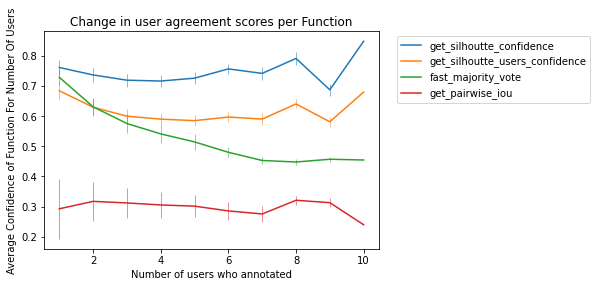

In [4]:
confidence_funcs = [ get_silhoutte_confidence, get_silhoutte_users_confidence, fast_majority_vote, get_pairwise_iou]
experiment_results = experiment_3(data, confidence_funcs, num_of_trials=1000, json_name="experiment_results_old.json")
processed = process_results(experiment_results)
generate_graph_all(processed)

In [9]:
processed

{'fast_majority_vote': {0: [],
  1: [1.0,
   0.5217391304347826,
   1.0,
   0.6875,
   0.5,
   0.925,
   0.9444444444444444,
   0.5,
   0.5416666666666666,
   0.8333333333333334,
   0.5625,
   0.5,
   0.6428571428571429,
   1.0,
   0.625,
   0.95,
   1.0,
   1.0,
   0.8,
   0.8,
   0.5,
   0.6136363636363636,
   0.5416666666666666,
   0.8333333333333334,
   0.5,
   0.75,
   0.890625,
   0.6304347826086957,
   0.95,
   0.5,
   0.9545454545454546,
   0.6111111111111112,
   0.5,
   0.6304347826086957,
   0.5,
   1.0,
   0.5403225806451613,
   0.5,
   0.717391304347826,
   0.56,
   0.5,
   0.875,
   1.0,
   0.9285714285714286,
   0.6875,
   0.5,
   0.5,
   0.6818181818181818,
   0.75,
   0.5],
  2: [1.0,
   0.4842767295597483,
   0.9375,
   0.6296296296296295,
   0.4999999999999999,
   0.7199999999999999,
   0.9629629629629629,
   0.5555555555555555,
   0.3888888888888889,
   0.6666666666666667,
   0.5185185185185185,
   0.37037037037037035,
   0.5,
   1.0,
   0.5384615384615384,
   0.9666

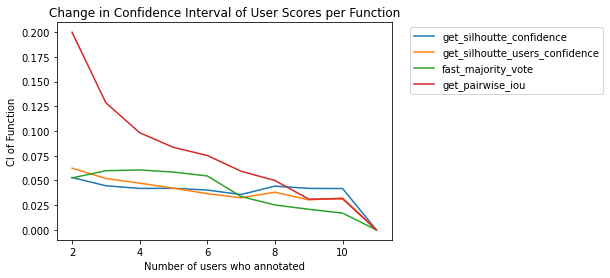

In [5]:
plot_change_in_ci(processed)

# Get JSON Copy of Last Experiment Ran

In [6]:
with open('./experiment_results.json', 'r') as fcc_file:
    experiment_results = json.load(fcc_file)
    print(experiment_results)

{'get_silhoutte_confidence': {'0': [], '1': [0.3563649052250318, 0.5903774597683469, 0.9746665925662353, 0.9311813921270669, 0.4104300129903845, 0.3978433186406213, 0.0, 0.30407130730889853, 0.3725080669987158, 0.2996703984127571, 0.32990276993598194, 0.5591496265843614, 0.9819875594708971, 0.29496024448026364, 0.47869213237663033, 0.0, 0.3988274630644245, 0.37440609493484295, 0.4924242356622268, 0.48660279020548974, 0.4807692246637642, 0.0, 0.3682646246980215, 0.3762228750428031, 0.2841154524879408, 0.0, 0.0, 0.5221085583902391, 0.990095405107789, 0.36231416980459796, 0.7284884508730045, 0.4650160536251593, 0.0, 0.3445199995028739, 0.9393458884186858, 0.3445199995028739, 0.37854815862775737, 0.3553246006870319, 0.0, 0.31688667297451656, 0.5628169258859382, 0.7921920139499294, 0.47869213237663033, 0.7676342432028034, 0.47751807736475355, 0.2506191785008715, 0.8925375029739722, 0.2734903803485126, 0.9499999965003028, 0.0, 0.0, 0.0, 0.4911677594052356, 0.4966356337108552, 0.2137880883200

In [7]:
def fast_majority_vote_new(df, users, chunk_length=1):
    df = df[df["LAST MOD BY"].isin(users)]
    df = fast_chunker(df, chunk_length)
    df["LAST MOD BY"] = df["LAST MOD BY"].apply(lambda x: len(x.split(",")))
    counts = (df["LAST MOD BY"]).mean()/len(users)
    return  counts

def fast_majority_vote_new2(df, users, chunk_length=5):
    df = df[df["LAST MOD BY"].isin(users)]
    df = fast_chunker(df, chunk_length)
    df["LAST MOD BY"] = df["LAST MOD BY"].apply(lambda x: len(x.split(",")))
    counts = (df["LAST MOD BY"]).mean()/len(users)
    return  counts


0
fast_majority_vote 0.1809990406036377
fast_majority_vote_new 0.5880012512207031
fast_majority_vote_new2 0.11199712753295898
1
fast_majority_vote 3.441997766494751
fast_majority_vote_new 8.87972903251648
fast_majority_vote_new2 2.2350821495056152
2
fast_majority_vote 0.7357711791992188
fast_majority_vote_new 1.5599877834320068
fast_majority_vote_new2 0.49012279510498047
3
fast_majority_vote 1.276552438735962
fast_majority_vote_new 2.8979532718658447
fast_majority_vote_new2 0.8120007514953613
4
fast_majority_vote 1.109769344329834
fast_majority_vote_new 2.248908042907715
fast_majority_vote_new2 0.6791510581970215
5
fast_majority_vote 1.3807742595672607
fast_majority_vote_new 3.332512855529785
fast_majority_vote_new2 0.8301715850830078
6
fast_majority_vote 0.6419715881347656
fast_majority_vote_new 1.199080228805542
fast_majority_vote_new2 0.4050440788269043
7
fast_majority_vote 0.23940777778625488
fast_majority_vote_new 0.7361621856689453
fast_majority_vote_new2 0.1407926082611084
8
fas

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice.
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: Mean of empty slice.
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\seanh\AppData\Roaming\Python\Python37

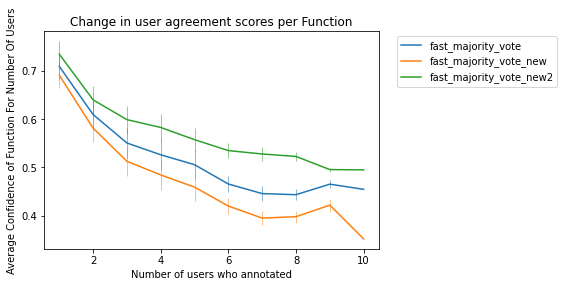

In [8]:
confidence_funcs = [ fast_majority_vote, fast_majority_vote_new, fast_majority_vote_new2]
experiment_results = experiment_3(data, confidence_funcs, num_of_trials=50, json_name="improved_majority_vote.json")
processed = process_results(experiment_results)
generate_graph_all(processed)

# Notes and Thoughts About Majority Vote and IOU

- Majority vote is a better techinque for GT isolation than agreement. If you have a clip with not many seconds in chunk, its still one users. I think It just doesn't really work in this context. (I did initally see it as user agreement)
- IOU for mutliple boxes still assumes one box is GT from what I can see online. Therefore I'm unsure about it's use here with unsupervised work
- IOU like majority vote could still be used as a GT isolation techinque, but probably not best used for measure agreement
- I think I need to go back to the books on IOU on zooniverse forums to figure out what works here
- Clustering might just be the way to go